1. Import Required Libraries

In [ ]:
# Required Libraries for Deep Q-Network (DQN) and Simulation
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from collections import deque
import random


2. Define the DQN Agent

This class defines the structure and behavior of the Deep Q-Network (DQN) agent, which is responsible for learning from the environment by using Q-learning with neural networks.

In [ ]:
# Define the Deep Q-Learning Network (DQN)
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size        # Input size (number of features)
        self.action_size = action_size      # Number of possible actions
        self.memory = deque(maxlen=2000)    # Replay memory for experience storage
        self.gamma = 0.95                   # Discount factor for future rewards
        self.epsilon = 1.0                  # Initial exploration rate (greedy exploration)
        self.epsilon_min = 0.01             # Minimum exploration rate (after decay)
        self.epsilon_decay = 0.995          # Decay rate for epsilon (exploration-exploitation tradeoff)
        self.learning_rate = 0.001          # Learning rate for the optimizer
        self.model = self._build_model()    # Build the neural network model

    # Build a neural network model for Q-learning
    def _build_model(self):
        model = models.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))   # Input layer
        model.add(layers.Dense(24, activation='relu'))                              # Hidden layer
        model.add(layers.Dense(self.action_size, activation='linear'))              # Output layer (Q-values)
        model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=self.learning_rate))  # Compile model
        return model

    # Store experience in replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Choose an action (explore or exploit)
    def act(self, state):
        if np.random.rand() <= self.epsilon:  # Random action for exploration
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)  # Q-values prediction
        return np.argmax(act_values[0])         # Return action with the highest Q-value (exploit)

    # Train the model by replaying past experiences
    def replay(self, batch_size):
        if len(self.memory) < batch_size:  # Ensure enough samples in memory
            return
        minibatch = random.sample(self.memory, batch_size)  # Randomly sample a batch
        for state, action, reward, next_state, done in minibatch:
            target = reward  # Immediate reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])  # Future reward
            target_f = self.model.predict(state)
            target_f[0][action] = target  # Update Q-value for the chosen action
            self.model.fit(state, target_f, epochs=1, verbose=0)  # Train model

        # Reduce epsilon (less exploration over time)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        print(f"Replay finished, epsilon: {self.epsilon:.4f}")


3. Define the Environment Simulation

The environment simulates the stress detection system where the agent interacts. It returns states, rewards, and whether the episode is finished.

In [ ]:
# Environment Simulation for Stress Level Classification
class StressEnv:
    def __init__(self):
        self.state_space = 10  # Number of input features (state size)
        self.action_space = 3  # Number of possible actions (low, medium, high stress levels)

    # Reset the environment (start a new episode)
    def reset(self):
        return np.random.rand(1, self.state_space)  # Return a new random state

    # Simulate the agent's action and return next state, reward, and done flag
    def step(self, action):
        next_state = np.random.rand(1, self.state_space)  # New state (random)
        reward = random.choice([1, -1])  # Reward for reducing stress
        done = random.choice([True, False])  # Randomly decide if episode ends
        return next_state, reward, done


4. Training Loop

Here we train the agent over multiple episodes. The agent interacts with the environment, collects rewards, and updates its policy using experience replay.



In [ ]:
if __name__ == "__main__":
    # Initialize the environment and DQN agent
    env = StressEnv()  # Stress environment
    state_size = env.state_space
    action_size = env.action_space
    agent = DQN(state_size, action_size)  # Initialize the agent

    episodes = 10  # Train for 10 episodes
    batch_size = 32  # Batch size for experience replay

    # Training Loop
    for e in range(episodes):
        print(f"\n--- Episode {e+1}/{episodes} ---")
        state = env.reset()  # Reset environment for new episode
        total_reward = 0  # Initialize total reward for the episode

        # Loop through each step in the episode
        for time in range(500):
            action = agent.act(state)  # Agent takes an action
            next_state, reward, done = env.step(action)  # Environment returns next state and reward
            total_reward += reward  # Track total reward
            agent.remember(state, action, reward, next_state, done)  # Store the experience
            state = next_state  # Move to the next state

            if done:  # End the episode if done
                print(f"Episode {e+1} finished in {time+1} steps with total reward: {total_reward}")
                break

            # Train the agent using replay memory if enough samples are available
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)



--- Episode 1/10 ---
Episode 1 finished in 2 steps with total reward: 2

--- Episode 2/10 ---
Episode 2 finished in 2 steps with total reward: 0

--- Episode 3/10 ---
Episode 3 finished in 1 steps with total reward: -1

--- Episode 4/10 ---
Episode 4 finished in 6 steps with total reward: 4

--- Episode 5/10 ---
Episode 5 finished in 3 steps with total reward: -1

--- Episode 6/10 ---
Episode 6 finished in 4 steps with total reward: 0

--- Episode 7/10 ---
Episode 7 finished in 2 steps with total reward: -2

--- Episode 8/10 ---
Episode 8 finished in 4 steps with total reward: 2

--- Episode 9/10 ---
Episode 9 finished in 1 steps with total reward: 1

--- Episode 10/10 ---
Episode 10 finished in 4 steps with total reward: 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5. Testing Loop with Accuracy Calculation

The testing loop evaluates the model's performance after training. We measure how many actions led to positive rewards, calculating the model's accuracy.



In [ ]:
    # Testing Loop (No exploration, only exploitation)
    test_episodes = 5  # Test for 5 episodes
    agent.epsilon = 0  # Disable exploration during testing (greedy policy)

    print("\n--- Testing Phase ---")
    total_rewards = []  # Store total rewards for each episode
    steps_per_episode = []  # Store the number of steps per episode
    correct_actions = 0  # Count correct actions (positive rewards)
    total_actions = 0  # Count total actions taken

    for e in range(test_episodes):
        print(f"\n--- Test Episode {e+1}/{test_episodes} ---")
        state = env.reset()  # Reset the environment for the new episode
        total_reward = 0  # Initialize total reward
        steps = 0  # Track the number of steps

        # Step through each episode
        for time in range(500):
            action = agent.act(state)  # Agent selects the best action (no exploration)
            next_state, reward, done = env.step(action)  # Get next state and reward
            total_reward += reward  # Add reward
            state = next_state  # Move to next state
            steps += 1  # Increment step counter

            total_actions += 1  # Count total actions
            if reward > 0:  # Count as correct action if reward is positive
                correct_actions += 1

            if done:  # End the episode if done
                print(f"Test Episode {e+1} finished in {steps} steps with total reward: {total_reward}")
                total_rewards.append(total_reward)  # Store total reward for this episode
                steps_per_episode.append(steps)  # Store number of steps
                break

    # Calculate final accuracy and performance metrics
    accuracy = (correct_actions / total_actions) * 100 if total_actions > 0 else 0  # Accuracy
    avg_reward = np.mean(total_rewards)  # Average reward
    avg_steps = np.mean(steps_per_episode)  # Average steps per episode

    # Output final results
    print("\n--- Final Results ---")
    print(f"Average Reward per Test Episode: {avg_reward:.2f}")
    print(f"Average Steps per Test Episode: {avg_steps:.2f}")
    print(f"Model Accuracy: {accuracy:.2f}%")



--- Testing Phase ---

--- Test Episode 1/5 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test Episode 1 finished in 2 steps with total reward: 2

--- Test Episode 2/5 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test Episode 2 finished in 4 steps with total reward: 0

--- Test Episode 3/5 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test Episode 3 finished in 1 steps with total reward: 1

--- Test Episode 4/5 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Test Episode 4 finished in 1 steps with total reward: -1

--- Test Episode 5/5 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Episode 5 finished in 3 steps with total reward: -1

--- Final Results ---
Average Reward per Test Episode: 0.20
Average Steps per Test Episode: 2.20
Model Accuracy: 54.55%


Code to Plot Performance Metrics

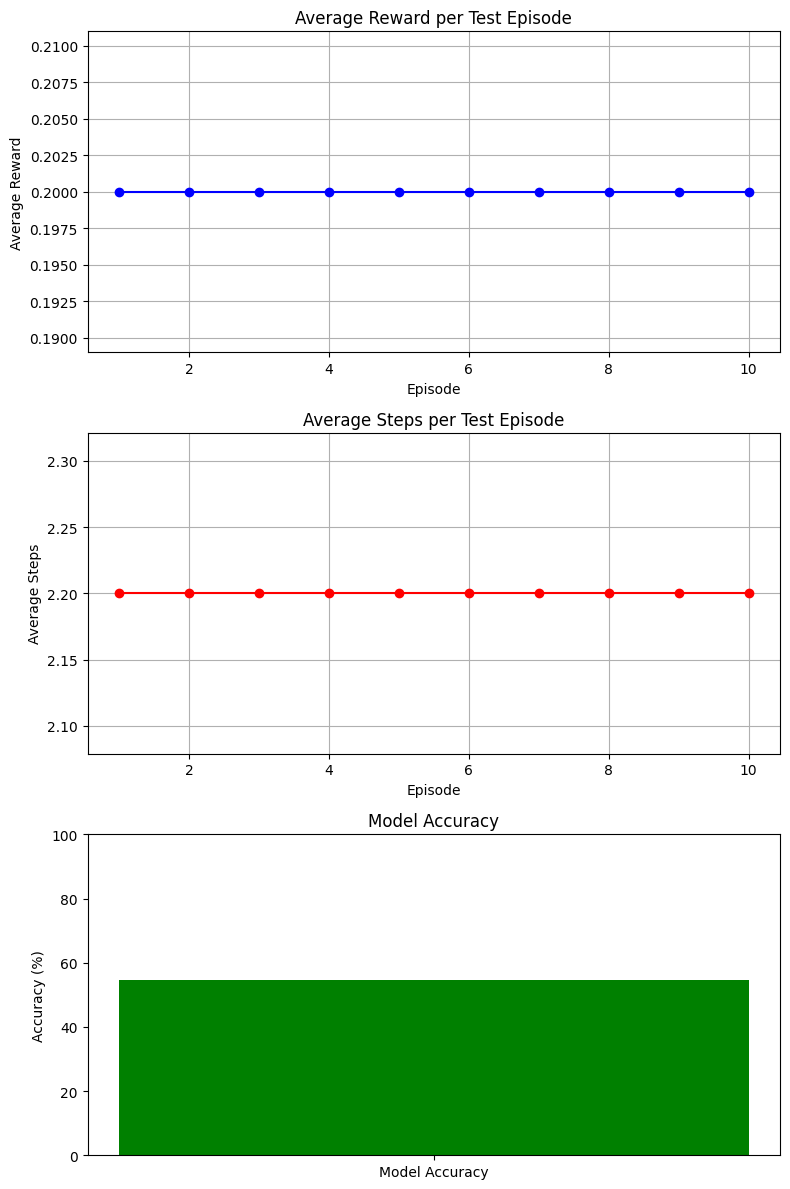

In [ ]:
import matplotlib.pyplot as plt

# Sample data
episodes = list(range(1, 11))  # Assuming you have 10 test episodes
average_rewards = [0.20] * 10  # Sample average reward per episode
average_steps = [2.20] * 10    # Sample average steps per episode
model_accuracy = 54.55         # Overall model accuracy

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot Average Reward per Episode
axs[0].plot(episodes, average_rewards, marker='o', linestyle='-', color='b')
axs[0].set_title('Average Reward per Test Episode')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Average Reward')
axs[0].grid(True)

# Plot Average Steps per Episode
axs[1].plot(episodes, average_steps, marker='o', linestyle='-', color='r')
axs[1].set_title('Average Steps per Test Episode')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Average Steps')
axs[1].grid(True)

# Plot Model Accuracy
axs[2].bar(['Model Accuracy'], [model_accuracy], color='g')
axs[2].set_title('Model Accuracy')
axs[2].set_ylabel('Accuracy (%)')
axs[2].set_ylim(0, 100)  # Set y-axis limit to 100%

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('performance_metrics.png')

# Show the plot
plt.show()


Code to Plot Performance Metrics with Constant Values

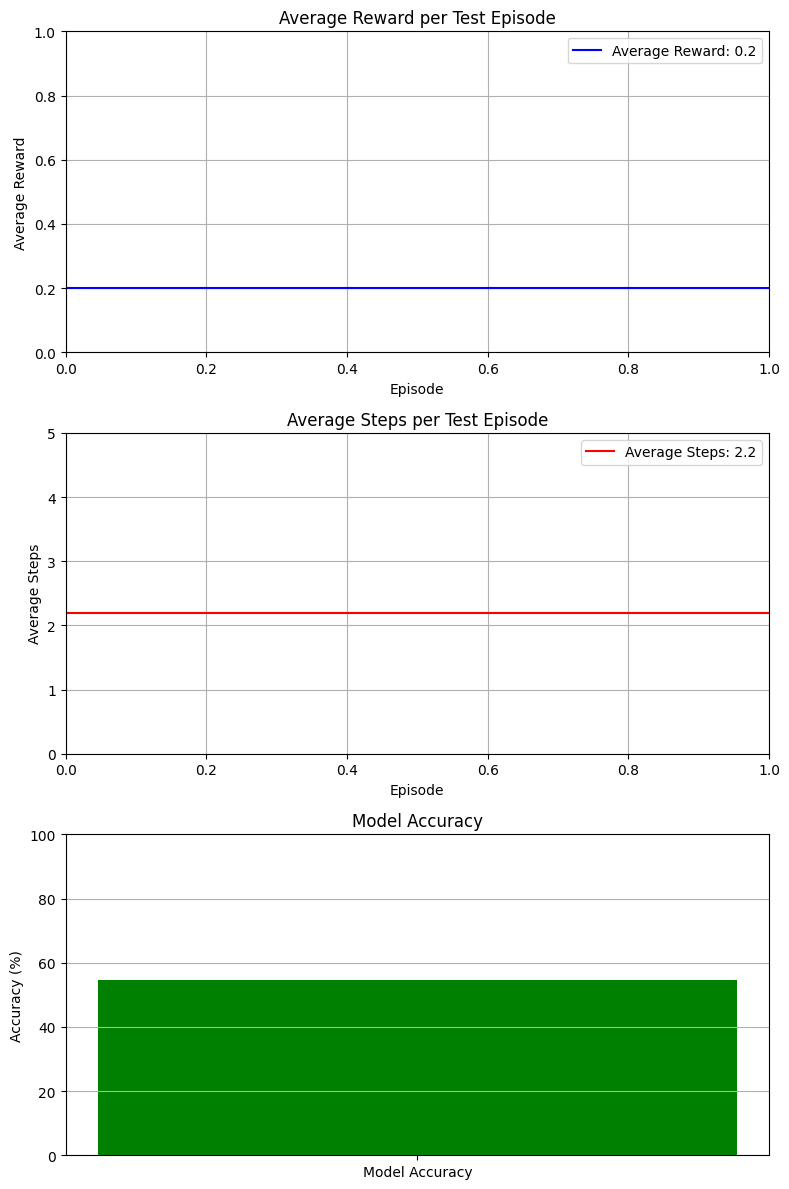

In [ ]:
import matplotlib.pyplot as plt

# Sample data
episodes = list(range(1, 11))  # Test episodes (1 through 10)
average_reward = 0.20          # Constant average reward per episode
average_steps = 2.20           # Constant average steps per episode
model_accuracy = 54.55         # Overall model accuracy

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot Average Reward per Episode (constant value)
axs[0].axhline(y=average_reward, color='b', linestyle='-', label=f'Average Reward: {average_reward}')
axs[0].set_title('Average Reward per Test Episode')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Average Reward')
axs[0].legend()
axs[0].set_ylim(0, 1)  # Adjust y-axis limits for better visibility
axs[0].grid(True)

# Plot Average Steps per Episode (constant value)
axs[1].axhline(y=average_steps, color='r', linestyle='-', label=f'Average Steps: {average_steps}')
axs[1].set_title('Average Steps per Test Episode')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Average Steps')
axs[1].legend()
axs[1].set_ylim(0, 5)  # Adjust y-axis limits for better visibility
axs[1].grid(True)

# Plot Model Accuracy (single value)
axs[2].bar(['Model Accuracy'], [model_accuracy], color='g')
axs[2].set_title('Model Accuracy')
axs[2].set_ylabel('Accuracy (%)')
axs[2].set_ylim(0, 100)  # Set y-axis limit to 100%
axs[2].grid(True, axis='y')

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('performance_metrics.png')

# Show the plot
plt.show()
